#Автокодировщики


In [ ]:
from tensorflow.keras.models import Model, Sequential # загружаем абстрактный класс базовой модели сети от кераса и последовательную модель
# Из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K # подтягиваем базовые керасовские функции
from tensorflow.keras.optimizers import Adam # загружаем выбранный оптимизатор
from tensorflow.keras import utils # загружаем утилиты кераса
from tensorflow.keras.datasets import mnist, fashion_mnist # загружаем готовые базы mnist
from tensorflow.keras.callbacks import LambdaCallback

import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
from tensorflow.keras.preprocessing import image # модуль для отрисовки изображения
import numpy as np # библиотека для работы с массивами данных
import pandas as pd # библиотека для анализа и обработки данных
from PIL import Image # модуль для отрисовки изображения
from sklearn.model_selection import train_test_split # модуль для разбивки выборки на тренировочную/тестовую
from sklearn.preprocessing import StandardScaler # модуль для стандартизации данных

import os #
from google.colab import drive #модуль для работы с google диском 
import time, random
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
drive.mount('/content/drive/') # монтируем google диск

Mounted at /content/drive/


In [ ]:
def baseAutoencoder(shape=(112,80,1)): # зададим функцию создания базового автокодировщика
    img_input = Input((shape)) # задаём входные размеры

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) # входные данные передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # затем пропускаем через слой нормализации данных 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # далее снова слой двумерной свёртки
    x = BatchNormalization()(x) # и еще слой нормализации данных
    x = MaxPooling2D()(x) # передаём на слой подвыборки, снижающий размерность поступивших на него данных

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # пропускаем через слой нормализации данных 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)  # далее снова слой двумерной свёртки
    x = BatchNormalization()(x) # и еще слой нормализации данных
    z = MaxPooling2D()(x) # передаём на слой подвыборки
    

    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z) # слой разжимает данные(с 28*20 на 56*40)
    x = BatchNormalization()(x) # слой нормализации данных
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    # Сжатие MaxPooling2D не применяем

    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) # слой разжимает данные(с 56*40 на 112*80)
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных

    # Финальный слой двумерной свертки, выдающий итоговое изображение
    x = Conv2D(shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) # указываем модель, с оригинальным изображением на входе в сеть и сжатым-разжатым на выходе из сети
    model.compile(optimizer=Adam(lr=0.0001),
                  loss='mean_squared_error') # компилируем модель с оптимайзером Адам и среднеквадратичной ошибкой

    return model # функция вернёт заданную модель

In [ ]:
def plotImages(xTrain, pred, shape=(112, 80)): # создадим функцию для вывода изображений как картинок
  n = 5  # количество картинок, которые хотим показать
  plt.figure(figsize=(14, 7)) # указываем размеры фигуры
  for i in range(n): # для каждой картинки из n(5)
      index = np.random.randint(0, pred.shape[0]) # startIndex - начиная с какого индекса хотим заплотить картинки
      # Показываем картинки из тестового набора
      ax = plt.subplot(2, n, i + 1) # выведем область рисования Axes
      plt.imshow(xTrain[index].reshape(shape)) # отрисуем правильные картинки в размере 112*80      
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

      # Показываем восстановленные картинки
      ax = plt.subplot(2, n, i + 1 + n) # выведем область рисования Axes 
      plt.imshow(pred[index].reshape(shape)) # отрисуем обработанные сеткой картинки в размере 112*80     
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
  plt.show()

In [ ]:
# Функция для расчета mse
def getMSE(x1, x2): # создадим функцию среднеквадратичной ошибки
  x1 = x1.flatten() # сплющиваем в одномерный вектор
  x2 = x2.flatten() # сплющиваем в одномерный вектор
  delta = x1 - x2 # находим разницу
  return sum(delta ** 2) / len(delta) # и возвращаем сумму квадратов разницы, делённую на длину разницы

In [ ]:
# Зададим пару массивов и проверим работу функции
x1 = np.array([1, 1, 1]) # создаем первый массив
x2 = np.array([1, 1, 1]) # создаем второй массив
print(getMSE(x1,x2)) # выведем ошибку полученную нашей функцией

0.0


In [ ]:
# Зададим пару массивов и проверим работу функции
x1 = np.array([1, 1, 1, 1]) # создаем первый массив
x2 = np.array([1, 1, 0, 0]) # создаем второй массив
print(getMSE(x1,x2)) # выведем ошибку полученную нашей функцией

0.5


## MINIST



In [ ]:
(xTrainMnist, yTrainMnist), (xTestMnist, yTestMnist) = mnist.load_data() # загружаем данные из базы с разбивкой на train/test
xTrainMnist = xTrainMnist.astype('float32')/255 # представляем в виде значений от 0 до 1
xTrainMnist = xTrainMnist.reshape(-1, 28, 28, 1) # меняем форму, приводим к нужным нам размерам
xTestMnist = xTestMnist.astype('float32')/255 # представляем в виде значений от 0 до 1
xTestMnist = xTestMnist.reshape(-1, 28, 28, 1) # меняем форму, приводим к нужным нам размерам

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
xTrainMnist.shape # Отобразим размерность массива xTrainMnist

(60000, 28, 28, 1)

In [ ]:
modelAutoMnist = baseAutoencoder((28,28,1)) # создаем автокодировщик

In [ ]:
modelAutoMnist.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496 

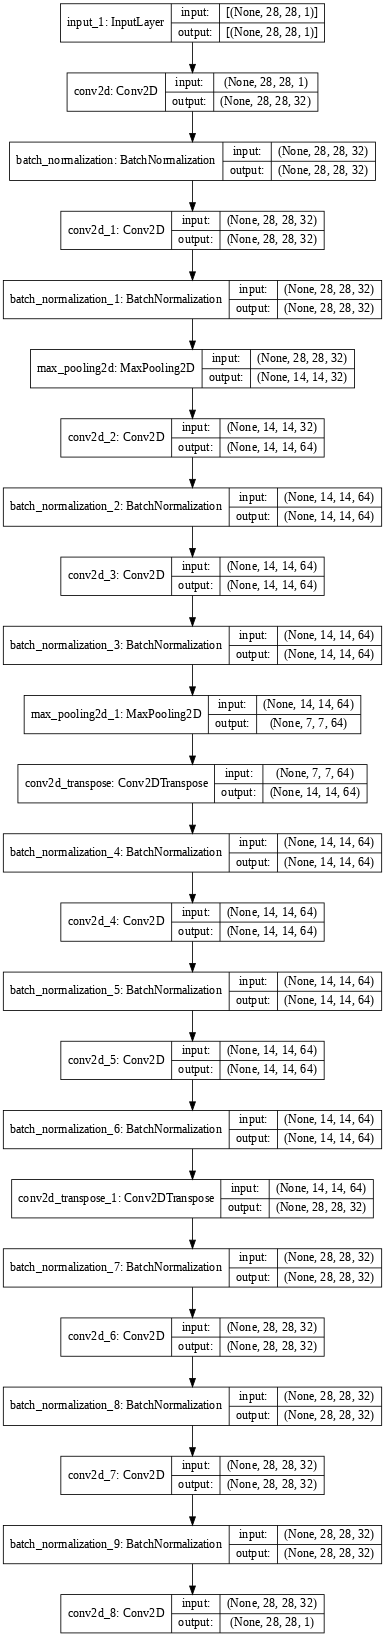

In [ ]:
utils.plot_model(modelAutoMnist, dpi=60, show_shapes=True)

In [ ]:
# Обучаем модель автокодировщика
history = modelAutoMnist.fit(xTrainMnist, xTrainMnist, epochs=100, batch_size=256, validation_data = (xTestMnist, xTestMnist))

Epoch 1/100
235/235 [==============================] - 44s 45ms/step - loss: 0.1239 - val_loss: 0.0964
Epoch 2/100
235/235 [==============================] - 10s 42ms/step - loss: 0.0165 - val_loss: 0.0144
Epoch 3/100
235/235 [==============================] - 10s 42ms/step - loss: 0.0087 - val_loss: 0.0064
Epoch 4/100
235/235 [==============================] - 10s 43ms/step - loss: 0.0062 - val_loss: 0.0053
Epoch 5/100
235/235 [==============================] - 10s 43ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 6/100
235/235 [==============================] - 10s 43ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 7/100
235/235 [==============================] - 10s 43ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 8/100
235/235 [==============================] - 10s 43ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 9/100
235/235 [==============================] - 10s 43ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 10/100
235/235 [==============================] - 10s 43ms/step - l

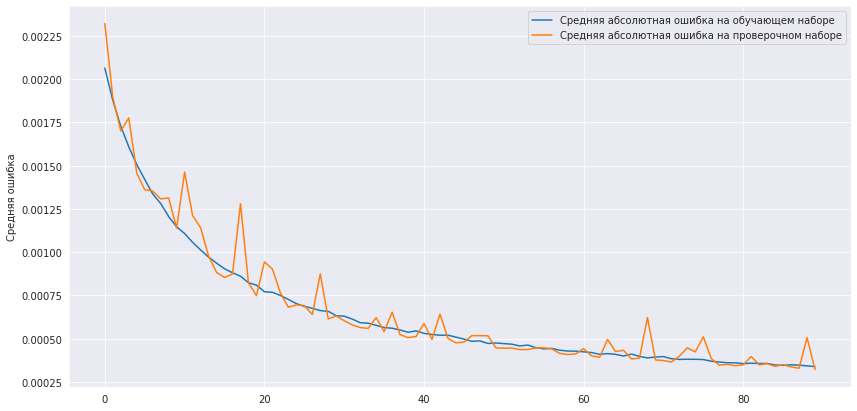

In [ ]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'][10:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][10:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
modelAutoMnist.save_weights('/content/drive/MyDrive/Nets/modelAutoMnist.h5') # Сохраняем модель
modelAutoMnist.load_weights('/content/drive/MyDrive/Nets/modelAutoMnist.h5') # Загружаем модель

In [ ]:
predMnistTest = modelAutoMnist.predict(xTestMnist) # Получаем результат работы модели на тестовой выборке
predMnistTest = predMnistTest * 255 # представляем в виде значений от 0 до 255
predMnistTest = predMnistTest.astype('uint8') # устанавливаем 8битовый тип

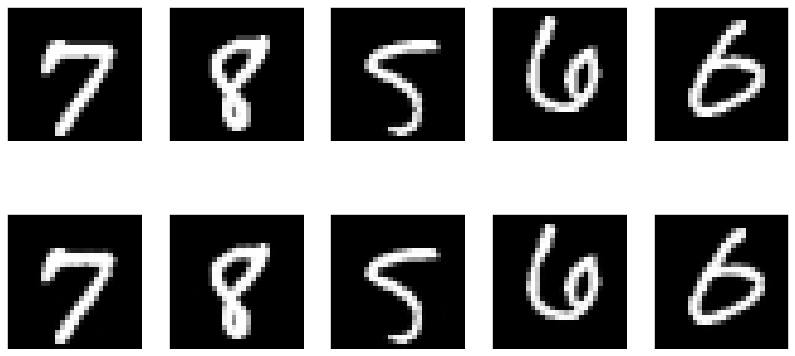

In [ ]:
plotImages(xTestMnist, predMnistTest, shape=(28,28)) # покажем исходные и восстановленные картинки

In [ ]:
predMnistTrain = modelAutoMnist.predict(xTrainMnist) # Получаем результат работы модели на обучающей выборке
predMnistTrain = predMnistTrain * 255 # представляем в виде значений от 0 до 255
predMnistTrain = predMnistTrain.astype('uint8') # устанавливаем 8битовый тип

In [ ]:
err1 = [getMSE(xTrainMnist[i], predMnistTrain[i] / 255) for i in range(len(predMnistTrain))]# Возьмем среднеквадратичную ошибку от правильной картинки и восстановленной (обучающая выборка)
err2 = [getMSE(xTestMnist[i], predMnistTest[i] / 255) for i in range(len(predMnistTest))]# Возьмем среднеквадратичную ошибку от правильной картинки и восстановленной (тестовая выборка)
print("Средняя ошибка на обучающем наборе MNIST:", sum(err1) / xTrainMnist.shape[0]) # Отобразим ошибку на обучающей выборке
print("Средняя ошибка на тестовом наборе MNIST:", sum(err2) /xTestMnist.shape[0] ) # Отобразим ошибку на тестовой выборке

Средняя ошибка на обучающем наборе MNIST: 0.00031154697742126665
Средняя ошибка на тестовом наборе MNIST: 0.0003208762504653683


### Fashion_mnist



In [ ]:
# Загрузим данные из fashion_mnist - базы с одеждой,обувью и т.п
(xTrainMnistF, yTrainMnistF), (xTestMnistF, yTestMnistF) = fashion_mnist.load_data()
xTrainMnistF = xTrainMnistF.astype('float32')/255 # представляем в виде значений от 0 до 1
xTrainMnistF = xTrainMnistF.reshape(xTrainMnistF.shape[0], 28, 28, 1) # меняем форму, приводим к нужным нам размерам

4423680/4422102 [==============================] - 0s 0us/step


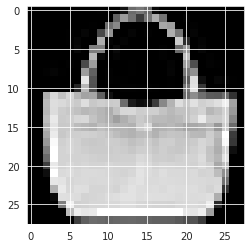

In [ ]:
# Взглянем на пример изображения из базы fashion_mnist
n = 100 # выбираем картинку
plt.imshow(xTrainMnistF[n].reshape((28,28)), cmap='gray') # переводим в 4х-канальное цветовое пространство RGBA
plt.show() # покажем картинку

In [ ]:
predMnistF = modelAutoMnist.predict(xTrainMnistF) # сделаем предикт для первых ста картинок из fashion_mnist
predMnistF = predMnistF * 255 # представляем в виде значений от 0 до 255
predMnistF = predMnistF.astype('uint8') # устанавливаем 8битовый тип

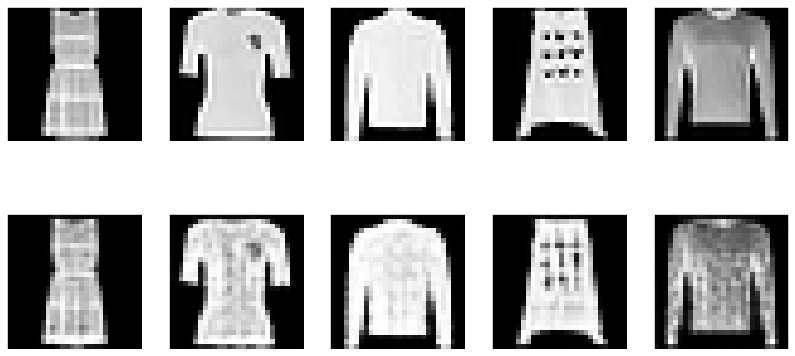

In [ ]:
plotImages(xTrainMnistF, predMnistF, shape=(28,28)) # выведем на экран картинки правильных и восстановленных изображений 

In [ ]:
# Возьмем среднеквадратичные ошибки и выведем их для Mnist и для базы с одеждой 
errF = [getMSE(xTrainMnistF[i], predMnistF[i] / 255) for i in range(len(predMnistF))]
print("Средняя ошибка на Mnist:", round(sum(err1) / len(err1), 4))
print("Средняя ошибка на одежде:", round(sum(errF) / len(errF), 4))
print()
print("Максимальная ошибка на Mnist:", round(max(err1),4))
print("Минимальная ошибка на одежде:", round(min(errF),4))

Средняя ошибка на Mnist: 0.0003
Средняя ошибка на одежде: 0.0056

Максимальная ошибка на Mnist: 0.0026
Минимальная ошибка на одежде: 0.0005


In [ ]:
bias = 0.0012 # установим какое-то пороговое значение
isMnist = [e < bias for e in err1] # запишем каждую ошибку больше порогового значения, Mnist
isMnistF = [e < bias for e in errF] # запишем каждую ошибку больше порогового значения, fashion_mnist

print("Mnist распознано, как Mnist: ", round(100*sum(isMnist) / len(isMnist), 2),"%", sep="")
print("Одежды распознано, как Mnist: ", round(100*sum(isMnistF) / len(isMnistF), 2),"%", sep="")
print("Суммарная ошибка: ", round(100*(1-(sum(isMnist) / len(isMnist)) + sum(isMnistF) / len(isMnistF))),"%", sep="")

Mnist распознано, как Mnist: 99.73%
Одежды распознано, как Mnist: 0.66%
Суммарная ошибка: 1%


### Визуализация

In [ ]:
def create_dense_ae(latent_dim): # объявляем функцию создания автокодировщика
    # Энкодер
    # Входной плейсхолдер
    input_img = Input(shape=(28, 28, 1)) # 28, 28, 1 - размерности строк, столбцов, фильтров одной картинки, без батч-размерности
    # Вспомогательный слой решейпинга
    flat_img = Flatten()(input_img)    
    # Кодированное полносвязным слоем представление
    encoded = Dense(latent_dim, activation='relu')(flat_img)    
    # Декодер
    # Раскодированное другим полносвязным слоем изображение
    input_encoded = Input(shape=(latent_dim,)) # задаем входную размерность (49,)
    flat_decoded = Dense(28*28, activation='sigmoid')(input_encoded) # далее полносвязный слой на 784 нейрона
    decoded = Reshape((28, 28, 1))(flat_decoded) # меняем форму, приводим к нужным нам размерам
    # Модели, в конструктор первым аргументом передаются входные слои, а вторым выходные слои
    # Другие модели можно так же использовать как и слои
    encoder = Model(input_img, encoded, name="encoder")    
    decoder = Model(input_encoded, decoded, name="decoder")    
    # Построим модель автокодировщика (внутри двойное преобразование - сжатие/разжатие)
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder # функция вернет 3 собранные сетки

In [ ]:
def on_epoch_end_AE(epoch, logs):
  print('________________________')  
  print('*** ЭПОХА:', epoch+1,'***')
  print('________________________')  
  plt.figure(figsize=(12,12))
  predict = encoder.predict(new_x_train)
  scatter = plt.scatter(predict[:,0,],predict[:,1], c=new_y_train, alpha=0.6)
  legend2 = plt.legend(*scatter.legend_elements(),loc="upper right", title="Классы")
  #plt.axis('off')
  plt.savefig('image'+str(epoch)+'.jpg')
  plt.show()
  print('loss: ', logs['loss'])

pltAE = LambdaCallback(on_epoch_end=on_epoch_end_AE)

Схема автокодировщика:


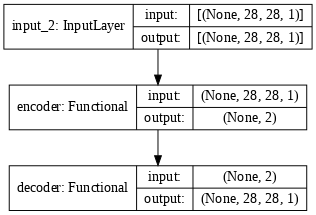

In [ ]:
encoder, decoder, autoencoder = create_dense_ae(2) # создаем три сетки с помощью заданной ранее функции
print('Схема автокодировщика:')
utils.plot_model(autoencoder, show_shapes=True, dpi=70)

Схема энкодера:


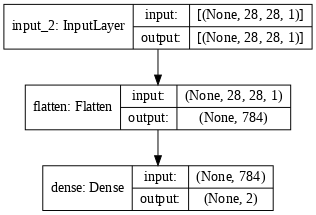

In [ ]:
print('Схема энкодера:')
utils.plot_model(encoder, show_shapes=True, dpi=70)

Схема декодера:


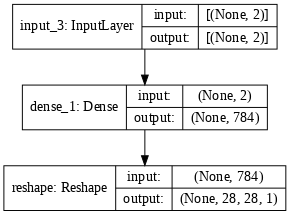

In [ ]:
print('Схема декодера:')
utils.plot_model(decoder, show_shapes=True, dpi=70)

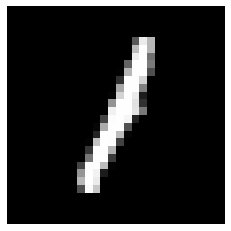

In [ ]:
test_img = xTestMnist[np.random.randint(len(xTestMnist))] # Берем случайное изображение из тестовой выборки
plt.imshow(test_img.reshape(28,28), cmap='gray') # Русуем изображение
plt.axis('off') # Отклюачем подписи осей
plt.show()

[[0.18713614 0.5988853 ]]


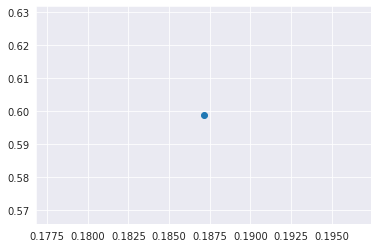

In [ ]:
koord = encoder.predict(test_img[None,...]) # Подаем изображение в декодер и получаем предикт (две координаты)
print(koord) # Печатаем координаты
scatter = plt.scatter(koord[0,0,],koord[0,1]) # Рисуем точку на плоскости
plt.show()

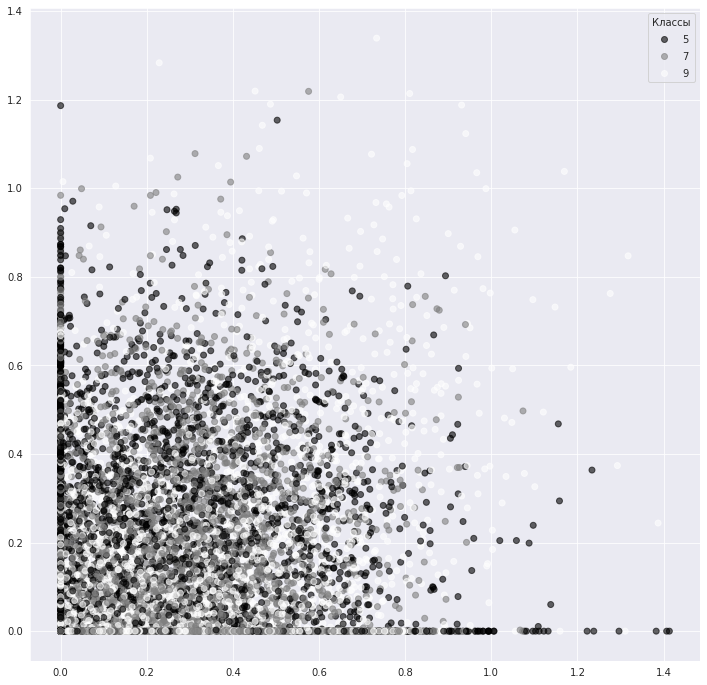

In [ ]:
numbers = [5, 7, 9] # Задаем цифры для визуализации
mask = np.array([(i in numbers) for i in yTrainMnist]) # Создаем маску по выбранным цифрам
new_x_train = xTrainMnist[mask] # Выбираем из xTrain только картики по маске
new_y_train = yTrainMnist[mask] # Выбираем из yTrain только метки по маске
plt.figure(figsize=(12,12)) # Задаем размер фигуры графика 
predict = encoder.predict(new_x_train) # Получаем предсказание энкодера
scatter = plt.scatter(predict[:,0,],predict[:,1], c=new_y_train, alpha=0.6) # Выводим точки для всех изображений
legend2 = plt.legend(*scatter.legend_elements(),loc="upper right", title="Классы") # Выводим легенду
plt.show()

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy') # компилируем модель с выбранным оптимайзером и функцией потерь 
classes = [0, 1, 3]
EPOCHS = 50
mask = np.array([(i in classes) for i in yTrainMnist])
new_x_train = xTrainMnist[mask]
new_y_train = yTrainMnist[mask]
autoencoder.fit(new_x_train, new_x_train,
                epochs=EPOCHS,
                batch_size=256,
                shuffle=True,
                callbacks = [pltAE],
                verbose=0)

In [ ]:
koord = np.array([[17, 12]]) # Возьмем точку с указанными координатами
result = decoder.predict(koord) # Используя обученный декодер, попробуем восстановить исходное изображение
print(result.shape) # Выведем размер полченного тензора

(1, 28, 28, 1)


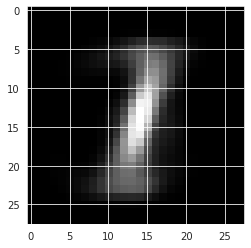

In [ ]:
plt.imshow(result[0].reshape(28,28), cmap='gray') # Выводим на экран полученное изображение
plt.show()

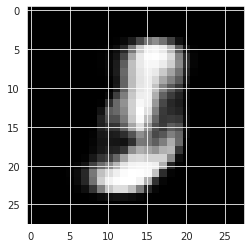

In [ ]:
koord = np.array([[23, 56]]) # Возьмем точку с указанными координатами
result = decoder.predict(koord) # Используя обученный декодер, попробуем восстановить исходное изображение
plt.imshow(result[0].reshape(28,28), cmap='gray') # Выводим на экран полученное изображение
plt.show()

In [ ]:
import imageio # Подключаем библиотеку imageio
images = [] # Создаем пустой список под изображения для gif
# Проходим в цикле 50 щагов
for i in range(50): 
    images.append(imageio.imread('image'+str(i)+'.jpg')) # Добавляем в список изображение очередную картинку
imageio.mimsave('AE.gif', images) # С помощью метода .mimsave() сохраняем анимацию

In [ ]:
from IPython.display import Image # Подключаем модуль Image
Image(open('AE.gif','rb').read()) # Визуализируем анимацию

##Лица

In [ ]:
!unzip -q '/content/drive/My Drive/Базы/Лица.zip' # распоковываем базу с лицами с google диска в colaboratory

In [ ]:
images_dir = 'Лица' # зададим имя папки в которую распоковали изображения
img_height = 112 # зададим высоту изображений
img_width = 80 # зададим ширину избражений

In [ ]:
# функция загрузки изображений, на вход принемает имя папки с изображениями, высоту и ширину к которой будут преобразованы загружаемые изображения
def load_images(images_dir, img_height, img_width): 
  list_images = [] # создаем пустой список в который будем загружать изображения
  for img in os.listdir(images_dir): # получим список изображений и для каждого изображения
  # добавим в список изображение в виде массива, с заданными размерами, в отенках серого
    list_images.append(image.img_to_array(image.load_img(os.path.join(images_dir, img), target_size=(img_height, img_width), color_mode='grayscale')))
  return np.array(list_images) # возвращаем numpy массив загруженных избражений

In [ ]:
cur_time = time.time() 
xTrain_imag = load_images(images_dir, img_height, img_width) # загрузим избражения лиц
print ('Время загрузки: ', round(time.time()-cur_time, 2), 'с', sep='')

Время загрузки: 31.81с


In [ ]:
xTrain_img = xTrain_imag/255 # отнормируем изображения от 0 до 1

In [ ]:
xTrain_img.shape # выведем размерность массива

(5018, 112, 80, 1)

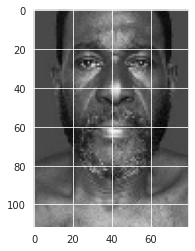

In [ ]:
plt.imshow(xTrain_img[np.random.randint(0, xTrain_img.shape[0])].reshape(112,80), cmap='gray') #выведем случайное изображение
plt.show()

In [ ]:
modelAutoFace = baseAutoencoder() # создаем автокодировщик

In [ ]:
# грузим данные в нашу модель, берём первые 4700 из xTrain_img и на вход, и на выход, в качестве проверочной берем оставшиеся из xTrain_img
modelAutoFace.fit(xTrain_img[:4700], xTrain_img[:4700], epochs=150, batch_size=100, validation_data = (xTrain_img[4700:], xTrain_img[4700:]))

Epoch 1/150
47/47 [==============================] - 11s 179ms/step - loss: 0.0659 - val_loss: 0.0711
Epoch 2/150
47/47 [==============================] - 8s 171ms/step - loss: 0.0136 - val_loss: 0.0710
Epoch 3/150
47/47 [==============================] - 8s 173ms/step - loss: 0.0081 - val_loss: 0.0682
Epoch 4/150
47/47 [==============================] - 8s 174ms/step - loss: 0.0064 - val_loss: 0.0648
Epoch 5/150
47/47 [==============================] - 8s 175ms/step - loss: 0.0054 - val_loss: 0.0592
Epoch 6/150
47/47 [==============================] - 8s 177ms/step - loss: 0.0048 - val_loss: 0.0524
Epoch 7/150
47/47 [==============================] - 8s 178ms/step - loss: 0.0044 - val_loss: 0.0444
Epoch 8/150
47/47 [==============================] - 8s 179ms/step - loss: 0.0042 - val_loss: 0.0351
Epoch 9/150
47/47 [==============================] - 8s 180ms/step - loss: 0.0039 - val_loss: 0.0262
Epoch 10/150
47/47 [==============================] - 8s 180ms/step - loss: 0.0037 - val_l

In [ ]:
modelAutoFace.save_weights('/content/drive/MyDrive/Nets/modelAutoFace.h5') # Сохраняем модель
modelAutoFace.load_weights('/content/drive/MyDrive/Nets/modelAutoFace.h5') # Загружаем модель

In [ ]:
predFace = modelAutoFace.predict(xTrain_img[:100]) # Получаем предсказание модели первых 100 лиц из обучающей выборки
predFace = predFace * 255 # представляем в виде значений от 0 до 255
predFace = predFace.astype('uint8') # устанавливаем 8битовый тип

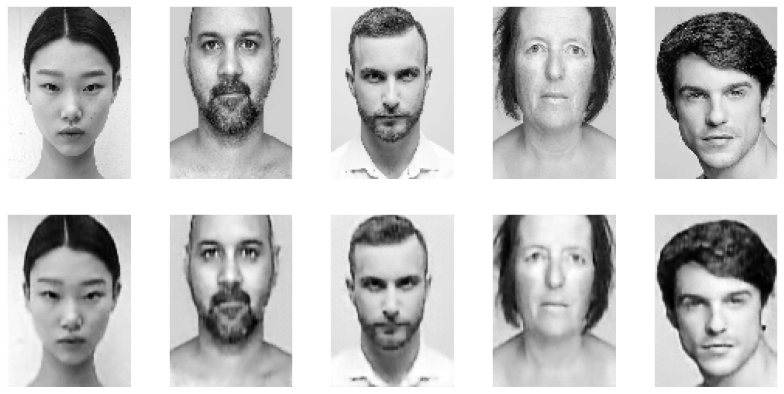

In [ ]:
plotImages(xTrain_img, predFace) #выведем оригинальные и сгенерированные автокодировщиком

In [ ]:
# Возьмем среднеквадратичные ошибки и выведем их для лиц 
errFace = [getMSE(xTrain_img[i], predFace[i] / 255) for i in range(len(predFace))] # посчитаем ошибку для всех изображений
print("Средняя ошибка на Лицах:", round(sum(errFace[80:]) / len(errFace[80:]), 4)) # посчитаем для последних 20 среднюю ошибку
print("Минимальная ошибка на Лицах:", round(min(errFace),4)) #найдем минимальную ошибку

Средняя ошибка на Лицах: 0.0009
Минимальная ошибка на Лицах: 0.0005


### Генерация из шума


In [ ]:
noise = np.random.sample((100,112,80,1)) # создаем 100 картинок шума
print(noise.shape) # выведем размеры

(100, 112, 80, 1)


In [ ]:
predNoise = modelAutoFace.predict(noise[:100]) # сделаем предикт этих шумовых картинок
predNoise = predNoise * 255 # представляем в виде значений от 0 до 255
predNoise = predNoise.astype('uint8') # устанавливаем 8битовый тип

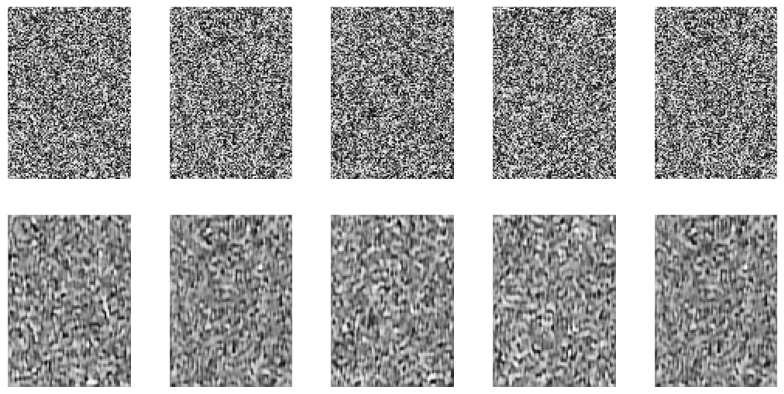

In [ ]:
plotImages(noise, predNoise) # выведем на экран исходные шумовые картинки и восстановленые 

In [ ]:
# Возьмем среднеквадратичные ошибки и выведем их для Mnist и для шумовых изображений
errN = [getMSE(noise[i], predNoise[i] / 255) for i in range(len(predNoise))]
print("Средняя ошибка на Лицах:", round(sum(errFace) / len(errFace), 4))
print("Средняя ошибка на шуме:", round(sum(errN) / len(errN), 4))
print("Максимальная ошибка на Лицах:", round(max(errFace),4))
print("Минимальная ошибка на шуме:", round(min(errN),4))

Средняя ошибка на Лицах: 0.001
Средняя ошибка на шуме: 0.0643
Максимальная ошибка на Лицах: 0.0039
Минимальная ошибка на шуме: 0.0623


In [ ]:
bias = 0.0073 # установим какое-то пороговое значение
isFace = [e < bias for e in errFace] # запишем каждую ошибку больше порогового значения, Mnist
isNoise = [e < bias for e in errN] # запишем каждую ошибку больше порогового значения, fashion_mnist

print("Лиц распознано, как Лиц: ", round(100*sum(isFace) / len(isFace)),"%", sep="")
print("Шума распознано, как Лиц: ", round(100*sum(isNoise) / len(isNoise)),"%", sep="")
print("Суммарная ошибка: ", round(100*(1-(sum(isFace) / len(isFace)) + sum(isNoise) / len(isNoise))),"%", sep="")

Лиц распознано, как Лиц: 100%
Шума распознано, как Лиц: 0%
Суммарная ошибка: 0%


### Удаление шума


In [ ]:
def addNoise(x, noiseVal): # объявим функцию добавления шума
  #noise = np.random.sample((x.shape[0],28,28,1))
  noise = np.random.normal(loc=0.5, scale=0.5, size=x.shape) # создаем шум(с центром в 0.5 и отклонением 0.5)
  
  # Cкладываем с произведением шума*на усилитель шума и вводим ограничение значений от 0 до 1(clip)
  return np.clip(x + noiseVal * noise, 0., 1.) 

In [ ]:
noisedXTrainFace = addNoise(xTrain_img, 0.05) # cоздаем зашумленный вариант лиц из xTrain_img

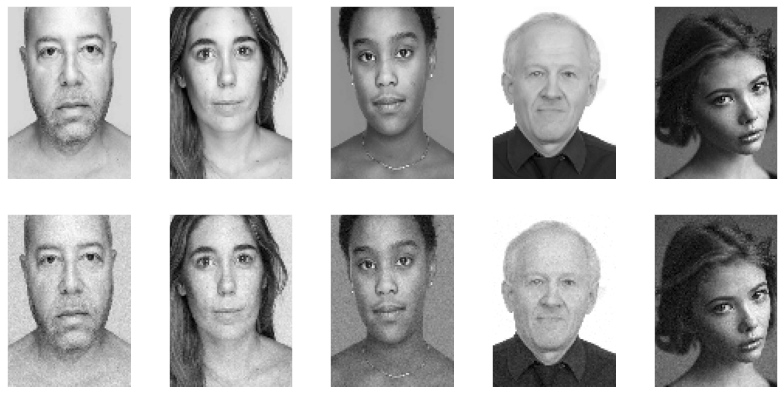

In [ ]:
plotImages(xTrain_img, noisedXTrainFace) # выведем на экран исходные лица и зашумленные варианты 

In [ ]:
def denoiseAutoencoder(): # объявляем функцию создания автокодировщика для подавления шума
    img_input = Input((112,80,1)) # задаём входные размеры

    # Добавляем четыре сверточных слоя, вместо MaxPooling используем strides
    x = Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(img_input)
    x = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Flatten()(x) # сплющиваем в одномерный вектор - размер 7*5*256
    z = Dense(256, activation='relu')(x) # добавляем полносвязный слой
    x = Dense(7*5*256, activation='relu')(z) # и еще полносвязный слой с переводом в 8960-мерное пространство(7*5*256)
    x = Reshape((7,5,256))(x) # меняем размеры - картинка 7*5 , 256 ядер
    x = Conv2DTranspose(256, (3, 3), strides=2, padding='same')(x) # разжимаем картинки из 7*5 до 14*10
    x = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x) # разжимаем картинки из 14*10 до 28*20
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x) # разжимаем картинки из 28*20 до 56*40
    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x) # разжимаем картинки из 56*40 до 112*80
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) # и пропускаем через финальный слой двумерной свертки

    model = Model(img_input, x) # собрали модель с зашумленной картинкой на вход и с очищенной от шума на выход
    model.compile(optimizer='adam',
                  loss='mse') # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки

    return model # функция вернет модель подавления шума

In [ ]:
modelDenoiseFace = denoiseAutoencoder()

In [ ]:
# Подаем на вход зашумленные картинки, а на выход правильные, исходные картинки, и обучаем
modelDenoiseFace.fit(noisedXTrainFace[:4700], xTrain_img[:4700], epochs=150, batch_size=100, validation_data = (noisedXTrainFace[4700:], xTrain_img[4700:]))

Epoch 1/150
47/47 [==============================] - 5s 87ms/step - loss: 0.0617 - val_loss: 0.0330
Epoch 2/150
47/47 [==============================] - 4s 82ms/step - loss: 0.0298 - val_loss: 0.0181
Epoch 3/150
47/47 [==============================] - 4s 83ms/step - loss: 0.0167 - val_loss: 0.0143
Epoch 4/150
47/47 [==============================] - 4s 83ms/step - loss: 0.0132 - val_loss: 0.0119
Epoch 5/150
47/47 [==============================] - 4s 83ms/step - loss: 0.0114 - val_loss: 0.0105
Epoch 6/150
47/47 [==============================] - 4s 84ms/step - loss: 0.0103 - val_loss: 0.0100
Epoch 7/150
47/47 [==============================] - 4s 84ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 8/150
47/47 [==============================] - 4s 84ms/step - loss: 0.0090 - val_loss: 0.0093
Epoch 9/150
47/47 [==============================] - 4s 85ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 10/150
47/47 [==============================] - 4s 85ms/step - loss: 0.0083 - val_loss: 0.0083

In [ ]:
modelDenoiseFace.save_weights('/content/drive/MyDrive/Nets/modelDenoiseFace.h5') # Сохраняем модель
modelDenoiseFace.load_weights('/content/drive/MyDrive/Nets/modelDenoiseFace.h5') # Сохраняем модель

In [ ]:
predFaceDenoise = modelDenoiseFace.predict(noisedXTrainFace[:4000]) # подаем 4тыс зашумленных картинок и делаем предикт
predFaceDenoise = predFaceDenoise * 255 # представляем в виде значений от 0 до 255
predFaceDenoise = predFaceDenoise.astype('uint8') # устанавливаем 8битовый тип

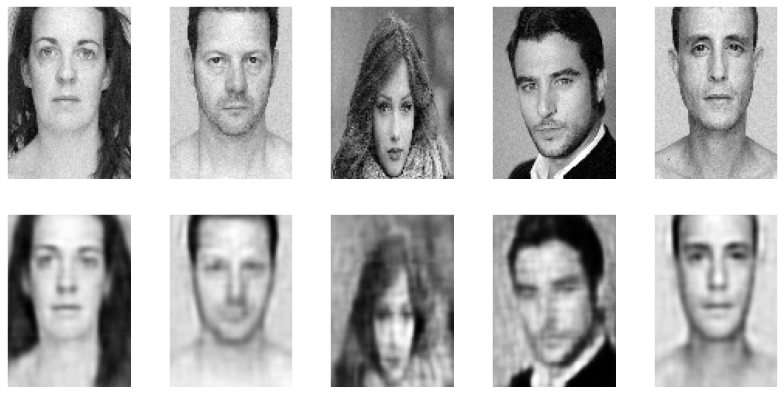

In [ ]:
plotImages(noisedXTrainFace, predFaceDenoise) # взглянем как отрабатывает шумоподавление на зашумленных картинках

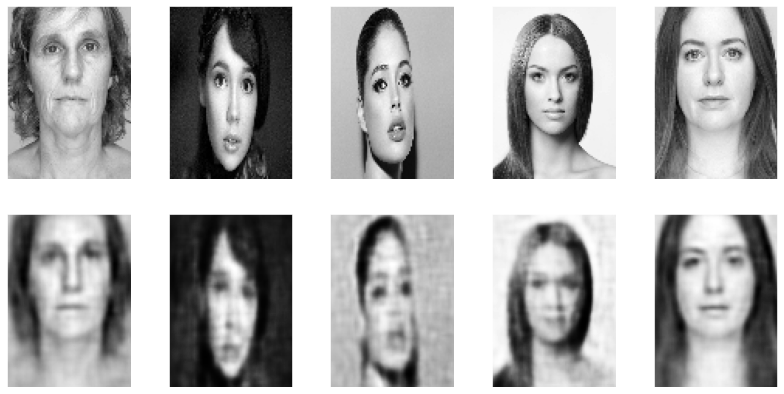

In [ ]:
plotImages(xTrain_img, predFaceDenoise) # взглянем как отрабатывает шумоподавление на лицах

## Определение мошеннических операций


In [ ]:
df = pd.read_csv("/content/drive/My Drive/Базы/creditcard.csv") # читаем базу

In [ ]:
df.head() # выводим первые пять строк

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Удаляем столбец со временем
data = df.drop(['Time'], axis=1)
# Нормализуем столбец с суммой транзакции
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

frauds = data[data.Class == 1] # записываем мошеннические операции
normal = data[data.Class == 0] # записываем нормальные операции

In [ ]:
frauds.shape # смотрим какие размеры у мошеннических операций

(492, 30)

In [ ]:
normal.shape # смотрим какие размеры у нормальных операций

(284315, 30)

In [ ]:
RANDOM_SEED = 42 # задаем случайное значение
# берём нормальные операции и разбиваем на train_test(только 'X')
X_train, X_test = train_test_split(normal, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# Удаляем класс в обучающем наборе данных
X_train = X_train.drop(['Class'], axis=1)
# Добавляем все мошеннические транзакции в тестовый набор данных
X_test = pd.concat([X_test, frauds])
# Делаем метки для тестового набора данных
y_test = X_test['Class']
# Удаляем класс у тестового набора данных
X_test = X_test.drop(['Class'], axis=1)
# Преобразуем данные в массивы numpy
X_train = X_train.values
X_test = X_test.values

In [ ]:
print(X_train.shape) # взглянем на размеры обучающих данных

(227452, 29)


In [ ]:
def creditcardAutoencoder(): # объявляем автокодировщик для определения мошенич.транзакций
  dataSize = X_train.shape[1] # берём размеры X_train по второй оси(30)
  dataInput = Input(shape=(dataSize, )) # задаем эти размеры как входные в сеть
  
  x = Dense(10, activation='relu')(dataInput) # пропускаем через полносвязный слой размером 10
  x = Dense(dataSize, activation='linear')(x) # и через полносвязный слой размером 29 
  
  autoencoder = Model(inputs=dataInput, outputs=x) # собрали модель 
  
  autoencoder.compile(optimizer='Adam', loss='mse') # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки
  
  return autoencoder 

In [ ]:
model = creditcardAutoencoder()

In [ ]:
history = model.fit(X_train, X_train,
                    epochs=50,
                    batch_size=32) # загружаем данные в модель(X_train'ы) и обучаем

Epoch 1/50
7108/7108 [==============================] - 12s 2ms/step - loss: 0.5915
Epoch 2/50
7108/7108 [==============================] - 12s 2ms/step - loss: 0.3575
Epoch 3/50
7108/7108 [==============================] - 11s 2ms/step - loss: 0.3545
Epoch 4/50
7108/7108 [==============================] - 12s 2ms/step - loss: 0.3540
Epoch 5/50
7108/7108 [==============================] - 12s 2ms/step - loss: 0.3575
Epoch 6/50
7108/7108 [==============================] - 12s 2ms/step - loss: 0.3576
Epoch 7/50
7108/7108 [==============================] - 12s 2ms/step - loss: 0.3552
Epoch 8/50
7108/7108 [==============================] - 12s 2ms/step - loss: 0.3514
Epoch 9/50
7108/7108 [==============================] - 11s 2ms/step - loss: 0.3516
Epoch 10/50
7108/7108 [==============================] - 11s 2ms/step - loss: 0.3556
Epoch 11/50
7108/7108 [==============================] - 12s 2ms/step - loss: 0.3535
Epoch 12/50
7108/7108 [==============================] - 12s 2ms/step - lo

In [ ]:
model.save_weights('/content/drive/MyDrive/Nets/modelCredit.h5') # Сохраняем модель
model.load_weights('/content/drive/MyDrive/Nets/modelCredit.h5') # Сохраняем модель

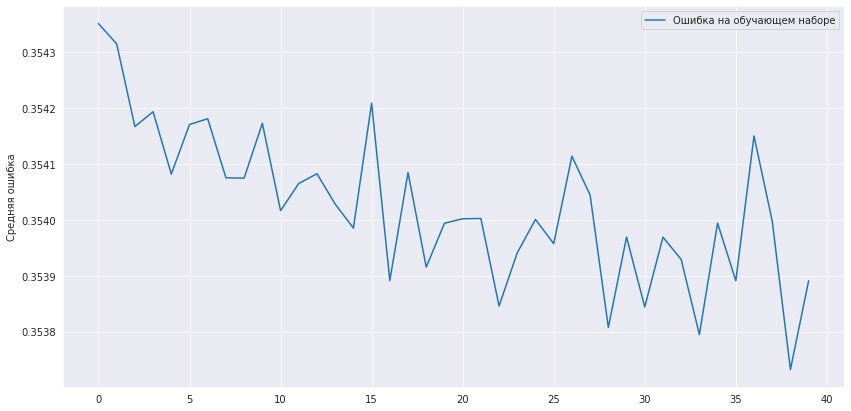

In [ ]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'][10:], 
         label='Ошибка на обучающем наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(X_test) # делаем предсказание по X_test

In [ ]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1) # определяем среднеквадратичную ошибку по X_test и предсказанием по X_test

In [ ]:
mse_normal = mse[y_test.values == 0] # среднеквадратичная ошибка на нормальных операциях
mse_frauds = mse[y_test.values == 1] # среднеквадратичная ошибка на мошеннических операциях

In [ ]:
print("Минимальная ошибка нормальных транзакций:", round(min(mse_normal),4)) #найдем минимальную среднеквадратичную ошибку на нормальных операциях
print("Максимальная ошибка нормальных транзакций:", round(max(mse_normal),4)) #найдем максимальную среднеквадратичную ошибку на нормальных операциях
print("Средняя ошибка нормальных транзакций:", round(sum(mse_normal) / len(mse_normal),4)) # среднюю ошибку

Минимальная ошибка нормальных транзакций: 0.0395
Максимальная ошибка нормальных транзакций: 355.0234
Средняя ошибка нормальных транзакций: 0.3553


In [ ]:
print("Минимальная ошибка мошеннических транзакций:", round(min(mse_frauds),4)) #найдем минимальную среднеквадратичную ошибку на мошеннических операциях
print("Максимальная ошибка мошеннических транзакций:", round(max(mse_frauds),4)) #найдем максимальную среднеквадратичную ошибку на мошеннических операциях
print("Средняя ошибка мошеннических транзакций:", round(sum(mse_frauds) / len(mse_frauds),4)) # среднюю ошибку

Минимальная ошибка мошеннических транзакций: 0.1599
Максимальная ошибка мошеннических транзакций: 101.0704
Средняя ошибка мошеннических транзакций: 19.6025


In [ ]:
def getAccByBias(bias): # функция будет принимать какое то пороговое значение
  isNormal = mse_normal < bias # если ошибка меньше порога - то транзакция нормальная
  isFrauds = mse_frauds > bias # если ошибка больше порога - то транзакция мошенническая

  accNormal = sum(isNormal) / len(isNormal) # вычисляем процент нормальных операций
  accFaruds = sum(isFrauds) / len(isFrauds) # вычисляем процент мошеннических операций

  print("Распознано нормальных транзакций: ", round(100*accNormal), "%", sep="")
  print("Распознано мошеннических транзакций: ", round(100*accFaruds), "%", sep="")
  print("Средняя точность распознавания: ", round(50*(accNormal + accFaruds)), "%", sep="")

In [ ]:
getAccByBias(0.65) # выведем данные по распознаванию с конкретным пороговым значением

Распознано нормальных транзакций: 93%
Распознано мошеннических транзакций: 90%
Средняя точность распознавания: 91%
